#Creación de una red neuronal artificial para predecir si el cliente cancelará la reserva del hotel (Clasificación binaria)
### Keras
Javier López González

Alejandro Ruiz

Carlos Espinoza

Miguel Barragan Rodriguez

## Import libraries



In [1]:
#para una barra de progreso durante el entrenamiento
from tqdm import tqdm
import time


# Tensorflow and tf.keras
import tensorflow as tf
from tensorflow import keras
from keras.callbacks import LambdaCallback
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

#Helper libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

ModuleNotFoundError: No module named 'tensorflow'

## Load data

In [3]:
import pandas as pd

In [6]:
# Modificación de las rutas en consecuencia para apuntar los archivos csv en su propio sistema de archivos gdrive..
ATT_FILE = "dataset/HotelReservationsPreparedCleanAttributes.csv"
LABEL_FILE = "dataset/HotelReservationsOutput.csv"

# División del conjunto de datos en tres particiones: el 80% para el entrenamiento, el 10% para las pruebas de validación y el 10% restante para las pruebas de test.
TRAIN_RATE = 0.8 # 80% del conjunto de datos se destina para el entrenamiento

attributes = pd.read_csv(ATT_FILE)
label = pd.read_csv(LABEL_FILE)

# Reducción de dimensionalidad con PCA
from sklearn.decomposition import PCA

pca = PCA(n_components = 4)

principalComponents = pca.fit_transform(attributes)
attributes = pd.DataFrame(data = principalComponents)

#Se obtiene el numero de ejemplos dentro del conjunto de datos para cada una de las partes
n_instances = attributes.shape[0]
n_train = int(n_instances*TRAIN_RATE)
n_dev = int((n_instances-n_train)/2) # 10% validation
n_final_test = int (n_instances-n_train-n_dev) # 10% test

#Se usa el numero de ejemplos para seleccionar cuantos se toman para cada parte
#Desde el principio hasta n_train para entrenamiento
x_train = attributes.values[:n_train]
t_train = label.values[:n_train]

#Desde donde acabo n_train hasta n_train + n_dev para validación
x_dev = attributes.values[n_train:n_train+n_dev]
t_dev = label.values[n_train:n_train+n_dev]

#Desde donde acabó n_dev hasta el final
x_test = attributes.values[n_train + n_dev:]
t_test = label.values[n_train + n_dev:]

#Imprimimos la forma de los conjuntos para comprobar que se ha hecho correctamente
#Hay 36270 ejemplos, 16 atributos de entrada y 1 de salida
# 36270 * 0.80 = 29016 ejemplos de entrenamiento
print ("x_train:",x_train.shape)
print ("t_train:",t_train.shape)

# 36270 * 0.1 = 3627 ejemplos de validación/test
print ("x_dev:",x_dev.shape)
print ("t_dev:",t_dev.shape)

print ("x_test:",x_test.shape)
print ("t_test:",t_test.shape)



x_train: (29016, 4)
t_train: (29016, 1)
x_dev: (3627, 4)
t_dev: (3627, 1)
x_test: (3627, 4)
t_test: (3627, 1)


Se ha hecho una división de los datos 80% - 10% - 10% para un total de 36270 ejemplos en los datos.
Esto equivale a:
* 29016 ejemplos para entrenamiento
* 3627 ejemplos para validación
* 3627 ejemplos para test

In [ ]:
# Balanceo de datos
"""!pip install imbalanced-learn
import imblearn
oversample = imblearn.over_sampling.RandomOverSampler(sampling_strategy='minority') # Balanceo aumentando la clase con menos muestras
x_train, t_train = oversample.fit_resample(x_train, t_train)
x_dev, t_dev = oversample.fit_resample(x_train, t_train)
t_train = t_train.reshape((len(t_train), 1))
t_dev = t_dev.reshape((len(t_train), 1))"""

"!pip install imbalanced-learn\nimport imblearn\noversample = imblearn.over_sampling.RandomOverSampler(sampling_strategy='minority') # Balanceo aumentando la clase con menos muestras\nx_train, t_train = oversample.fit_resample(x_train, t_train)\nx_dev, t_dev = oversample.fit_resample(x_train, t_train)\nt_train = t_train.reshape((len(t_train), 1))\nt_dev = t_dev.reshape((len(t_train), 1))"

## Initialize variables

In [ ]:
INPUTS = x_train.shape[1]
OUTPUTS = t_train.shape[1]
NUM_TRAINING_EXAMPLES = int(round(x_train.shape[0]/1))
NUM_DEV_EXAMPLES = int (round (x_dev.shape[0]/1))
NUM_TEST_EXAMPLES = int (round (x_test.shape[0]/1))

Se muestran algunos datos para comprobar que son correctos:

In [ ]:
x_train[:5]

array([[ 0.        , -1.        , -0.71428571, -0.64705882, -1.        ,
        -1.        ,  0.        , -1.        ,  0.27272727, -0.4       ,
         0.        , -1.        , -1.        , -1.        , -0.54074074,
        -1.        ],
       [ 0.        , -1.        , -0.42857143, -0.64705882, -1.        ,
        -1.        ,  0.        ,  0.32731377,  1.        ,  0.86666667,
         0.        , -1.        , -1.        , -1.        , -0.69588889,
        -0.6       ],
       [-0.5       , -1.        , -0.42857143, -0.88235294,  0.        ,
        -1.        ,  0.        , -0.4717833 ,  0.27272727, -1.        ,
        -1.        , -1.        , -1.        , -1.        , -0.73148148,
        -1.        ],
       [-0.5       , -1.        , -1.        , -0.88235294, -1.        ,
        -1.        ,  0.        , -0.98645598,  0.81818182,  0.53333333,
         1.        ,  1.        , -0.84615385, -0.89655172, -0.75185185,
        -0.6       ],
       [ 0.        , -1.        , -1

In [ ]:
t_train[:5]

array([[1],
       [1],
       [1],
       [1],
       [0]])

In [ ]:
x_dev[:5]

array([[-0.5       , -1.        , -1.        , -0.88235294, -1.        ,
        -1.        ,  0.        , -1.        ,  0.45454545, -0.46666667,
         1.        , -1.        , -1.        , -1.        , -0.57777778,
        -1.        ],
       [ 0.        , -1.        , -1.        , -0.76470588, -1.        ,
        -1.        ,  0.        ,  0.10609481, -0.09090909,  0.06666667,
        -1.        , -1.        , -1.        , -1.        , -0.72222222,
        -1.        ],
       [ 0.        , -1.        , -0.42857143, -0.41176471, -1.        ,
        -1.        ,  0.        , -0.87358916,  0.81818182, -0.93333333,
        -1.        , -1.        , -1.        , -1.        , -0.84655556,
        -1.        ],
       [ 0.        , -1.        , -0.42857143, -0.64705882, -1.        ,
        -1.        ,  0.        , -0.13318284,  0.45454545,  0.6       ,
        -1.        , -1.        , -1.        , -1.        , -0.62222222,
        -1.        ],
       [ 0.        , -1.        , -0

In [ ]:
t_dev[:5]

array([[1],
       [0],
       [1],
       [0],
       [0]])

In [ ]:
x_test[:5]

array([[ 0.        , -1.        , -0.71428571, -0.76470588, -1.        ,
        -1.        ,  0.        , -0.82844244, -0.27272727,  0.46666667,
         0.        , -1.        , -1.        , -1.        , -0.53      ,
        -0.6       ],
       [-0.5       , -1.        , -1.        , -0.88235294, -1.        ,
         1.        ,  0.        , -0.99097065, -0.27272727, -0.33333333,
         1.        ,  1.        , -1.        , -0.75862069, -0.75185185,
        -1.        ],
       [ 0.        , -1.        , -0.71428571, -0.64705882, -1.        ,
        -1.        ,  0.        , -0.76072235, -0.45454545, -0.33333333,
         0.        , -1.        , -1.        , -1.        , -0.71637037,
        -0.6       ],
       [ 0.        , -1.        , -1.        , -0.76470588,  0.        ,
        -1.        ,  0.        ,  0.16027088,  0.09090909, -1.        ,
         0.        , -1.        , -1.        , -1.        , -0.62407407,
        -1.        ],
       [ 0.        , -1.        , -0

In [ ]:
t_test[:5]

array([[0],
       [1],
       [1],
       [0],
       [1]])

## Set hyperparameters

La tasa de aprendizaje $\alpha$, el tamaño del batch y el número de neuronas en la/las capas ocultas son los tres hiperparámetros a ajustar. El proceso de aprendizaje se detiene cuando alcanza el número de epochs indicado.

Recordemos que un **epoch** significa presentar todo el conjunto de datos de entrenamiento a la red neuronal.

Adoptamos un descenso de gradiente por mini lotes como estrategia de actualización de parámetros con un tamaño de mini lotes de *batch_size*. Dado que el tamaño del conjunto de datos de entrenamiento es *P=29.016*, una época consta de *P/batch_size* iteraciones de aprendizaje por epoch.

In [ ]:
n_epochs = 600
lr = 0.01
batch_size = 512
n_hidden = 256
n_layers = 11

## Build the model
Una arquitectura de red neuronal 16 - capas ocultas - 1 totalmente conectada

In [ ]:
model = keras.Sequential(name="model")

Definición de la topología de la red neuronal profunda. Se tiene en cuenta que la función de activación **tanh** se elige para la capa oculta debido a que los valores de nuestros datos están comprendidos en el rango (-1,1). Por otra parte se usa **sigmoid** para la capa de salida porque esta función alcanza sus límites en 0 y 1, esto nos conviene porque la salida esperada de la red debe ser 0 o 1 indicando si se cancela la reserva del hotel o no se cancela respectivamente.

In [ ]:
from keras.layers import Dropout, BatchNormalization
model.add(keras.layers.InputLayer(input_shape=(INPUTS,), batch_size=None)) #INPUT = 16 atributos
for _ in range(n_layers):
  model.add(keras.layers.Dense(n_hidden, activation="relu"))
  Dropout(0.6)
model.add(keras.layers.Dense(OUTPUTS, activation="sigmoid")) #OUTPUTS = 1 etiqueta
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 256)               1280      
                                                                 
 dense_1 (Dense)             (None, 256)               65792     
                                                                 
 dense_2 (Dense)             (None, 256)               65792     
                                                                 
 dense_3 (Dense)             (None, 256)               65792     
                                                                 
 dense_4 (Dense)             (None, 256)               65792     
                                                                 
 dense_5 (Dense)             (None, 256)               65792     
                                                                 
 dense_6 (Dense)             (None, 256)               65792 

There are 13,003 parameters to adjust in the learning process.

## Compile the model



Compilar el modelo significa especificar:
* La función de *pérdida*, la $entropía cruzada$ en este caso ya que nuestro problema es de clasificación y más especificamente clasificación binaria. Esta función mide la discrepancia entre las predicciones y las etiquetas reales en un problema de clasificación.
* El *optimizador* Gradient Descent a utilizar, dado que se ha estudiado en clase.
* Una lista de *métricas* adicionales (Precisión) a calcular durante el entrenamiento y la evaluación, en este caso se usa la precisión binaria dado que calcula la frecuencia con la que las predicciones coinciden con las etiquetas binarias.

In [ ]:
# La función de pérdida debe ser la entropía cruzada binaria y la precisión binaria como métrica.
# decaimiento del learning rate:
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    lr,
    decay_steps=500,
    decay_rate=0.96,
    staircase=True)
model.compile(loss='binary_crossentropy',
              optimizer=tf.keras.optimizers.SGD(learning_rate=lr_schedule, nesterov=True, momentum = 0.9),
              metrics=[tf.keras.metrics.BinaryAccuracy(threshold=0.5)])

There are several loss functions, optimizers, and metrics. Full lists are available at: https://keras.io/losses/, https://keras.io/optimizers/ and https://keras.io/metrics/.

## Train the model with Mini-Batch Gradient Descent



In [ ]:
# Crear un objeto tqdm para el bucle de entrenamiento
progress_bar = tqdm(total=n_epochs, desc='Training Progress', position=0)
from keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor = "val_loss", patience = 20)
start = time.perf_counter()
history = model.fit(x_train, t_train, batch_size=batch_size, epochs=n_epochs, verbose=0, validation_data=(x_dev, t_dev), callbacks=[LambdaCallback(on_epoch_end=lambda epoch, logs: progress_bar.update(1)), early_stopping])
progress_bar.close()
print(time.perf_counter() - start)

Training Progress:  39%|███▉      | 236/600 [01:20<02:04,  2.93it/s]

80.61076684499997


El entrenamiento es más rápido con verbose=0 que con verbose=1, pero este último nos permite depurar el código.

## Get the results


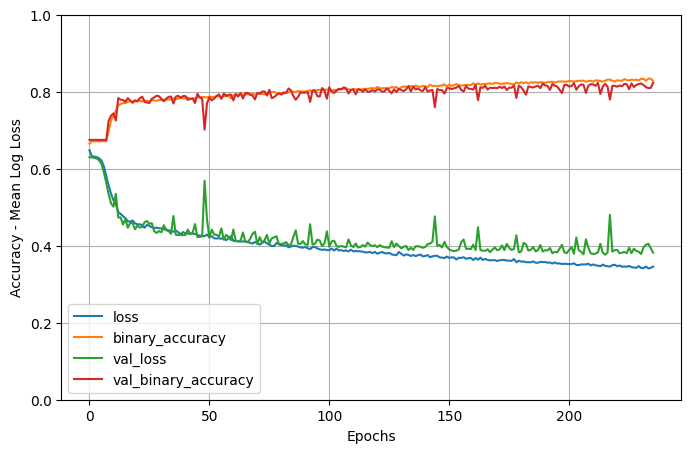

In [ ]:
results=pd.DataFrame(history.history)
results.plot(figsize=(8, 5))
plt.grid(True)
plt.xlabel ("Epochs")
plt.ylabel ("Accuracy - Mean Log Loss")
plt.gca().set_ylim(0, 1) # set the vertical range to [0-1]
plt.show()

In [ ]:
results[-1:]

,loss,binary_accuracy,val_loss,val_binary_accuracy
235,0.345772,0.82806,0.382121,0.822994


Veamos cómo predice el modelo en el conjunto de validación:

In [ ]:
dev_predictions=model.predict(x_dev).round(2)
dev_predictions[:20]

114/114 [==============================] - 1s 2ms/step


array([[0.95],
       [0.02],
       [0.99],
       [0.34],
       [0.02],
       [0.96],
       [0.65],
       [0.7 ],
       [0.99],
       [0.2 ],
       [0.02],
       [0.98],
       [0.49],
       [0.25],
       [0.01],
       [0.63],
       [0.43],
       [0.9 ],
       [0.98],
       [0.96]], dtype=float32)

In [ ]:
dev_rounded_predictions=np.round(dev_predictions).astype(int)
dev_rounded_predictions[:20]

array([[1],
       [0],
       [1],
       [0],
       [0],
       [1],
       [1],
       [1],
       [1],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [1],
       [0],
       [1],
       [1],
       [1]])

In [ ]:
t_dev[:20] #target classes

array([[1],
       [0],
       [1],
       [0],
       [0],
       [1],
       [0],
       [1],
       [1],
       [1],
       [0],
       [1],
       [0],
       [0],
       [0],
       [1],
       [0],
       [1],
       [1],
       [1]])

In [ ]:
#dev_correct_predictions = np.equal(np.argmax(dev_rounded_predictions,1),np.argmax(t_dev,1))
#print (dev_correct_predictions[:30])

dev_correct_predictions = (dev_rounded_predictions == t_dev)
print(dev_correct_predictions[:20])

[[ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [False]
 [ True]
 [ True]
 [False]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]]


In [ ]:
from collections import Counter
# Aplanar el array 2D a una lista de booleanos
dev_correct_predictions_flat = dev_correct_predictions.flatten()
#print(dev_correct_predictions_flat[:20])

# Convertir el array a una lista de enteros
dev_correct_predictions_list = list(dev_correct_predictions_flat.astype(int))
#print(dev_correct_predictions_list[:20])

# Usar Counter con la lista
counter_result = Counter(dev_correct_predictions_list)

# Mostrar el resultado
print(counter_result)
#1 = la cantidad de Trues, es decir, la cantidad de coincidencias entre la prediccion y el valor esperado
#0 = la cantidad de False, es decir, la cantidad de discrepancias entre la prediccion y el valor esperado

Counter({1: 2988, 0: 639})


####Confusion Matrix

In [ ]:
# Obtener las predicciones y etiquetas verdaderas como arrays de 0 y 1
dev_binary_predictions = np.round(dev_predictions).flatten()
dev_binary_targets = t_dev.flatten()

# Calcular la matriz de confusión
conf_matrix = confusion_matrix(dev_binary_targets, dev_binary_predictions)

# Crear un DataFrame para visualizar la matriz de confusión
c_m = pd.DataFrame(conf_matrix, columns=['True_Negative', 'True_Positive'])
c_m.insert(0, 'Classes', ['Pred_Negative', 'Pred_Positive'])
c_m['Sum'] = c_m.sum(axis=1, numeric_only=True)

print('Confusion Matrix:')
print(c_m)

Confusion Matrix:
         Classes  True_Negative  True_Positive   Sum
0  Pred_Negative            766            413  1179
1  Pred_Positive            226           2222  2448


####Clasification metrics

**Precisión** es la proporción de observaciones correctamente predichas en una clase respecto al total de observaciones predichas para esa clase (fila). La pregunta que responde esta métrica es: de todas las predicciones etiquetadas como una especie, ¿cuántas realmente pertenecen a esa clase?

$Precision = \frac{TP}{TP+FP}$

**Recall** es la proporción de observaciones correctamente predichas respecto a todas las observaciones en la clase real (columna). La pregunta que responde recall es: de todas las observaciones que realmente pertenecen a una clase, ¿cuántas etiquetó correctamente el modelo? Por lo general, el recall se refiere a la clase positiva, también conocida como *sensibilidad*, mientras que el recall de la clase negativa se denomina *especificidad*.

Recall (sensitivity) $= \frac{TP}{TP+FN}$

Specificity $= \frac{TN}{TN+FP}$

**F1 score** es el promedio ponderado de Precisión y Recall. Por lo tanto, este puntaje tiene en cuenta ambas clases de errores. Intuitivamente, no es tan fácil de entender como la precisión, pero el F1 suele ser más útil que la precisión, especialmente si tienes una distribución desigual de clases. La exactitud funciona mejor si la precisión y el recall tienen costos similares. Si el costo de los falsos positivos y falsos negativos es muy diferente, es mejor considerar tanto la precisión como el recall.

f1-score $= \frac{2(Recall * Precision)} {Recall + Precision}$

In [ ]:
print('Classification Report')
print(classification_report(dev_binary_targets, dev_binary_predictions, target_names=['Class_0', 'Class_1']))

Classification Report
              precision    recall  f1-score   support

     Class_0       0.77      0.65      0.71      1179
     Class_1       0.84      0.91      0.87      2448

    accuracy                           0.82      3627
   macro avg       0.81      0.78      0.79      3627
weighted avg       0.82      0.82      0.82      3627



In [ ]:
# COMPROBAR EL MODELO CON LOS DATOS DE TEST

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
# Obtener las predicciones del modelo en el conjunto de test
predictions = model.predict(x_test)

# Redondear las predicciones para un problema de clasificación binaria
rounded_predictions = np.round(predictions)

# Calcular métricas de evaluación
accuracy = accuracy_score(t_test, rounded_predictions)
precision = precision_score(t_test, rounded_predictions)
recall = recall_score(t_test, rounded_predictions)
f1 = f1_score(t_test, rounded_predictions)

# Imprimir o utilizar las métricas según sea necesario
print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1-score: {f1}')

# También puedes imprimir la matriz de confusión
conf_matrix = confusion_matrix(t_test, rounded_predictions)
# Crear un DataFrame de Pandas con nombres de filas y columnas
confusion_df = pd.DataFrame(conf_matrix, index=['Negativo', 'Positivo'], columns=['Pred_Negativo', 'Pred_Positivo'])
print('Confusion Matrix:')
print(confusion_df)

114/114 [==============================] - 0s 2ms/step
Accuracy: 0.8141714915908465
Precision: 0.8378173550587343
Recall: 0.8998778998778999
F1-score: 0.8677394034536892
Confusion Matrix:
          Pred_Negativo  Pred_Positivo
Negativo            742            428
Positivo            246           2211
